## Emotions - Classification with CNN

In the first step - we read the libraries and prepare our data.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import multiprocessing
from tensorflow.keras.callbacks import EarlyStopping

As the data is saved in different folders that indicates the emotion to be classified, we need to read the pixels to a pandas dataframe and also add the emotion class to this picture. This is done in the read_data function.

In [ ]:
# Base file path

def read_data(base_path):
    # List of folders with labels
    folders = [
        'angry',
        'disgust',
        'fear',
        'happy',
        'neutral',
        'sad',
        'surprise'
    ]


    # Initialize empty lists for images and labels
    df=pd.DataFrame(columns=["images","labels"])

    # Iterate through the folders and collect images and labels
    i=0
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            image_files = os.listdir(folder_path)
            image_files.sort()
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                # Open the image and save it in RGB format
                image = Image.open(image_path)#.convert('RGB')
                # Convert the image to a NumPy array
                image = np.array(image)
                df.loc[i,"images"]=image
                df.loc[i,"labels"]=folder
                i+=1

    return df


The data is saved in google drive, so we connect to it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then we read the pictures from the train and validation dataset, and combine them into one dataset.

In [ ]:
#train_path = '../Data/Emotions/train'
#test_path = '../Data/Emotions/validation'

train_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/train'
test_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/validation'
train_df = read_data(train_path)
test_df=read_data(test_path)
df=pd.concat([train_df,test_df])

Some sanity check, we want to see whether we read the data correctly. We print 10 pictures per class to have an idea.

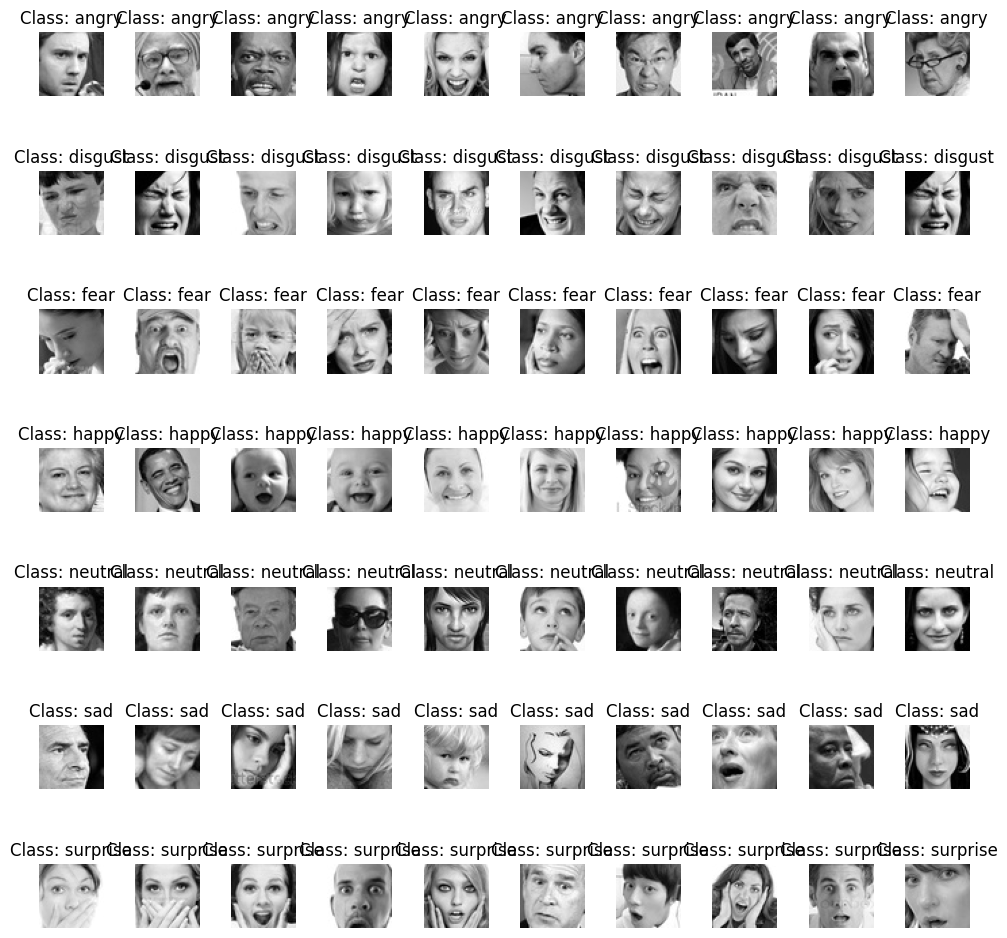

In [ ]:
classes_to_plot = 7
images_per_class = 10
fig, axs = plt.subplots(classes_to_plot, images_per_class, figsize=(12, 12))

for i, label in enumerate(df['labels'].unique()):
    class_data = df[df['labels'] == label].head(images_per_class)
    for j, (_, row) in enumerate(class_data.iterrows()):
        ax = axs[i, j]
        ax.imshow(row['images'], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Class: {label}')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

We can check how the number of pictures per class varies. On the plot below we can notice that the classes are imbalanced. For this we will need a resample strategy.

<Axes: xlabel='labels'>

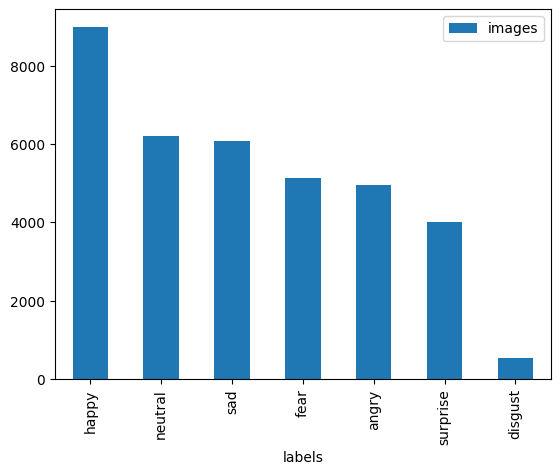

In [ ]:
df.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

But first we split the data into a train, validation and test datasets. We use stratified sampling on the labels base.

In [ ]:
df=df.sample(frac=1,random_state=0)
train,temp=train_test_split(df, test_size=0.3, random_state=0,shuffle=True,stratify=df["labels"])
val,test=train_test_split(temp, test_size=0.3, random_state=0,shuffle=True,stratify=temp["labels"])

Here we use Oversampling as a resampling strategy. We resample every class from the training dataset, so that every class has the same number of example  as the class happy. This class had the biggest number of pictures. The validation and test sets are unchanged.

In [ ]:
oversample=RandomOverSampler(sampling_strategy="auto",random_state=0)
X_over, y_over = oversample.fit_resample( train[["images"]], train[["labels"]])

In [ ]:
frames = [X_over, y_over]
train_oversampled = pd.concat(frames,axis=1)
train_oversampled =train_oversampled.sample(frac=1,random_state=0)


In [ ]:
train_oversampled

,images,labels
19959,"[[51, 60, 45, 31, 40, 39, 43, 41, 50, 78, 40, ...",fear
15414,"[[206, 173, 172, 177, 182, 168, 217, 170, 148,...",fear
2293,"[[27, 28, 24, 18, 14, 13, 16, 22, 35, 50, 59, ...",sad
41704,"[[187, 174, 154, 159, 159, 156, 152, 157, 158,...",surprise
8242,"[[3, 1, 20, 103, 217, 132, 134, 154, 104, 148,...",angry
...,...,...
30403,"[[66, 35, 11, 16, 36, 53, 71, 88, 105, 121, 13...",disgust
21243,"[[254, 252, 169, 88, 81, 56, 96, 89, 78, 73, 9...",happy
42613,"[[158, 137, 153, 171, 195, 205, 196, 195, 181,...",surprise
43567,"[[149, 146, 146, 153, 162, 164, 164, 165, 158,...",surprise


As we can see, the class are now evenly distributed.

<Axes: xlabel='labels'>

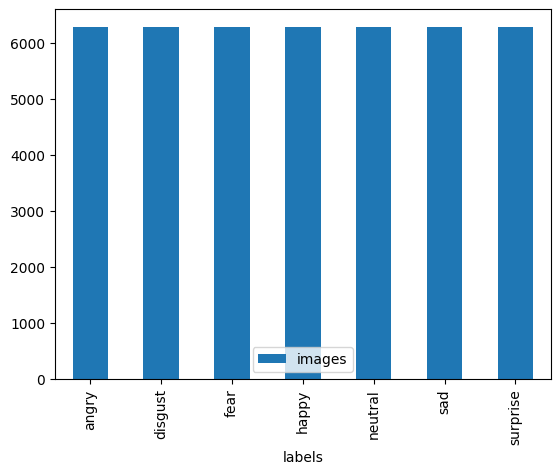

In [ ]:
 train_oversampled.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

For better generalization we also created the image data generator. We used some data augumentation methods for training generator, such as: rotation, zoom range and sheer range. The generators for test and validation only rescale the data.

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
validation_datagen = ImageDataGenerator(
      # rescale the pixel values (between 0 and 255) to the [0,1] interval
       rescale=1./255
)

In [ ]:
np.array(train_oversampled['labels'])

array(['fear', 'fear', 'sad', ..., 'surprise', 'surprise', 'angry'],
      dtype=object)

In [ ]:
# Step 1: Convert "images" to a NumPy ndarray
X_train = np.array(train_oversampled['images'].tolist())

# Step 2: Convert "labels" into a NumPy ndarray
y_train = np.array(train_oversampled['labels'])

# Checking the shape of the created arrays
print("Shape von X_train:", X_train.shape)
print("Shape von y_train:", y_train.shape)

Shape von X_train: (44044, 48, 48)
Shape von y_train: (44044,)


In [ ]:
train_oversampled['labels']

19959        fear
15414        fear
2293          sad
41704    surprise
8242        angry
           ...   
30403     disgust
21243       happy
42613    surprise
43567    surprise
2732        angry
Name: labels, Length: 44044, dtype: object

In [ ]:
mapping = {'angry':0,
    'disgust':1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprise':6}
train_oversampled['labels'] = train_oversampled['labels'].map(mapping)
#X_train = np.array(train_oversampled['images'].tolist()
X_train_plot=np.expand_dims(X_train[10].reshape((1,) + X_train[1].shape), axis=-1)
X_train=np.stack(train_oversampled["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_train=np.expand_dims(X_train, axis=-1)
y_train=train_oversampled["labels"].values

In [ ]:
X_val=np.stack(val["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_val=np.expand_dims(X_val, axis=-1)
val["labels"]=val["labels"].map(mapping)
y_val=val["labels"].values

In [ ]:
X_test=np.stack(test["images"].to_numpy())
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [ ]:
X_train_plot.shape

(1, 48, 48, 1)

In [ ]:
y_train_cat=to_categorical(y_train)
y_train_cat


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_val_cat=to_categorical(y_val)
y_val_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test_cat=to_categorical(y_test)
y_test_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
batch_size = 8

train_iterator  = train_datagen.flow(X_train,  y_train_cat,
                                    batch_size=64)
validation_iterator = validation_datagen.flow(X_val,
                                              y_val_cat,
                                              batch_size=64)

test_iterator = test_datagen.flow(X_test,
                                              y_test_cat,
                                              batch_size=64)


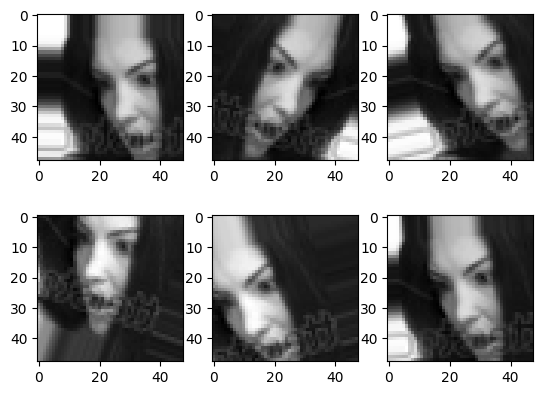

In [ ]:
def plotImages(x):
    i = 1
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(2,3,i)
        imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='gray')
        i += 1
        if i % 7 == 0:
            break
    plt.show()

plotImages(X_train_plot)


## Training models with CNN layers.
In this part we will train the network containing CNN layers in different configuration.
The first model contains only three CNN layers and three Dense layers. The second model is a bit bigger and contains 4 CNN layers and 3 Dense layers. In the third model we added strong regularizartion and in the fourth we gave it a bit more liberty and took away part of the regularization.

### First model

In this model we have three CNN layers (254,128 and 64 neurons) with a filter size of 3. We added padding to preserve the size after filtering. We added pooling between CNN layers.
After the flattening we have 2 Dense layers (128 and 254 neurons) with activation relu. In the output layer we have 7 neurons (each for every class) and softmax as the activation function.

In [ ]:
model = tf.keras.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(254, (3, 3),padding = 'same', activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3),padding = 'same', activation='relu'),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(254, activation='relu'),
    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)  # Output layer with 7 classes
])

We use categorical accuracy as the validation metric and categorical crossentropy as loss. We use also Adam optimizer with learning rate 1e-3.

In [ ]:
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
              loss=loss,
              metrics=[metric_accuracy])

We train the model for 25 epochs. The batch size is 128. For training we use the training iterator and validation iterator for validation. We also use the early stopping - if the valindetion loss does not improve in six following epochs, we stop the training in order to ommit

In [ ]:


early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
)

history = model.fit(
    train_iterator,
    epochs=25,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=validation_iterator  # Validation data
)


Epoch 1/25
689/689 [==============================] - 42s 58ms/step - loss: 1.9068 - categorical_accuracy: 0.2016 - val_loss: 1.8499 - val_categorical_accuracy: 0.2063
Epoch 2/25
689/689 [==============================] - 35s 51ms/step - loss: 1.8030 - categorical_accuracy: 0.2743 - val_loss: 1.7352 - val_categorical_accuracy: 0.2963
Epoch 3/25
689/689 [==============================] - 32s 46ms/step - loss: 1.6997 - categorical_accuracy: 0.3322 - val_loss: 1.6348 - val_categorical_accuracy: 0.3718
Epoch 4/25
689/689 [==============================] - 31s 45ms/step - loss: 1.6095 - categorical_accuracy: 0.3756 - val_loss: 1.5284 - val_categorical_accuracy: 0.4061
Epoch 5/25
689/689 [==============================] - 32s 46ms/step - loss: 1.5329 - categorical_accuracy: 0.4092 - val_loss: 1.3915 - val_categorical_accuracy: 0.4628
Epoch 6/25
689/689 [==============================] - 32s 47ms/step - loss: 1.4788 - categorical_accuracy: 0.4314 - val_loss: 1.4410 - val_categorical_accuracy:

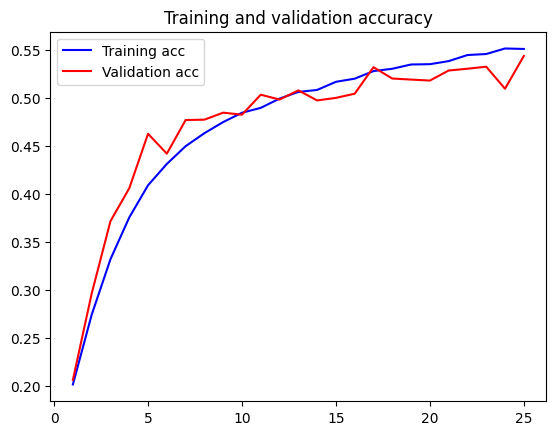

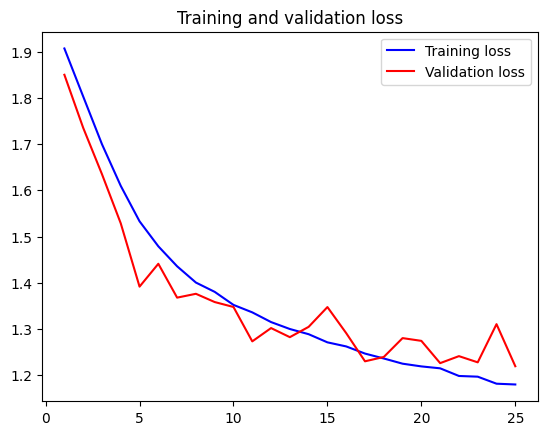

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

On the plots for loss and accuracy for train and validation data above we can see that the lines for validation follow n the lines for training nicely.  But when we evaluate the model we can see that it has only 0.198 accuracy.

In [ ]:
model.evaluate(X_val, y_val_cat)

236/236 [==============================] - 2s 6ms/step - loss: 441.7439 - categorical_accuracy: 0.1986


[441.7438659667969, 0.19864650070667267]

In [ ]:
predicted=np.argmax(model.predict(X_test), axis=1)
predicted

101/101 [==============================] - 1s 4ms/step


array([5, 2, 6, ..., 5, 4, 6])

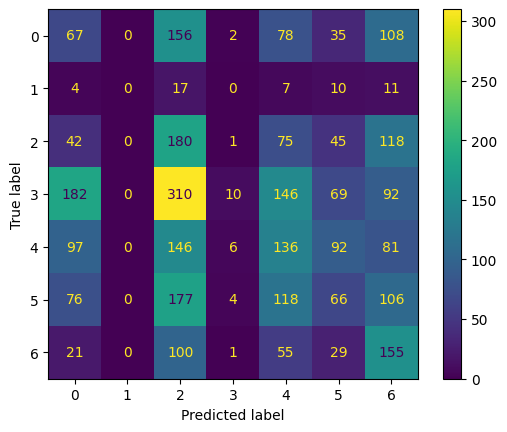

Accuracy: 0.19003404518724853
Recall: [0.15022422 0.         0.39045553 0.01236094 0.2437276  0.12065814
 0.42936288]
Precision: [0.13701431 0.         0.16574586 0.41666667 0.22113821 0.19075145
 0.23099851]
Precision: [0.14331551 0.         0.23270847 0.0240096  0.23188406 0.14781635
 0.3003876 ]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)


As we can see in the confusion matrix, the model did not learn the class disgust. The model is also not predicting classes 1-3.The accuracy on the test data is 15.5% and having a closer look at the analysing precision, recall and f1-score, we can see that the metrics are 0's for classes 1-3.

We will move to the bigger model.

### Second model

In this model twe have four CNN layers (254, 512, 254 and 512) with filter size of 3. We added padding to preserve the size after filtering. We added pooling between CNN layers. After the flattening we have 2 Dense layers (128 and 254 neurons) with activation relu. In the output layer we have 7 neurons (each for every class) and softmax as the activation function.

In [ ]:
model2 = tf.keras.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(254, (3, 3),padding = 'same', activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3),padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(254, (3, 3),padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(254, activation='relu'),
    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)  # Output layer with 10 classes (CIFAR-10)
])

We use categorical accuracy as the validation metric and categorical crossentropy as loss. We use also Adam optimizer with learning rate 1e-3.

In [ ]:
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
              loss=loss,
              metrics=[metric_accuracy])

In [ ]:
num_threads = multiprocessing.cpu_count()
num_threads

2

We train the model for 20 epoch. The batch size is 128. For training we use the training iterator and validation iterator for validation. We also use the early stopping - if the valindetion loss does not improve in the six following epoch, we stop the training in order to ommit overfitting.


In [ ]:
history =model2.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val_cat),  # Validation data
    workers=num_threads,
    use_multiprocessing=True#,
)


Epoch 1/20
345/345 [==============================] - 36s 93ms/step - loss: 2.3552 - categorical_accuracy: 0.2294 - val_loss: 1.8571 - val_categorical_accuracy: 0.2297
Epoch 2/20
345/345 [==============================] - 31s 89ms/step - loss: 1.4749 - categorical_accuracy: 0.4320 - val_loss: 1.5487 - val_categorical_accuracy: 0.4031
Epoch 3/20
345/345 [==============================] - 31s 89ms/step - loss: 1.1982 - categorical_accuracy: 0.5446 - val_loss: 1.4643 - val_categorical_accuracy: 0.4473
Epoch 4/20
345/345 [==============================] - 30s 87ms/step - loss: 1.0171 - categorical_accuracy: 0.6181 - val_loss: 1.5497 - val_categorical_accuracy: 0.4497
Epoch 5/20
345/345 [==============================] - 30s 86ms/step - loss: 0.8660 - categorical_accuracy: 0.6827 - val_loss: 1.5973 - val_categorical_accuracy: 0.4666
Epoch 6/20
345/345 [==============================] - 30s 86ms/step - loss: 0.7250 - categorical_accuracy: 0.7363 - val_loss: 1.7603 - val_categorical_accuracy:

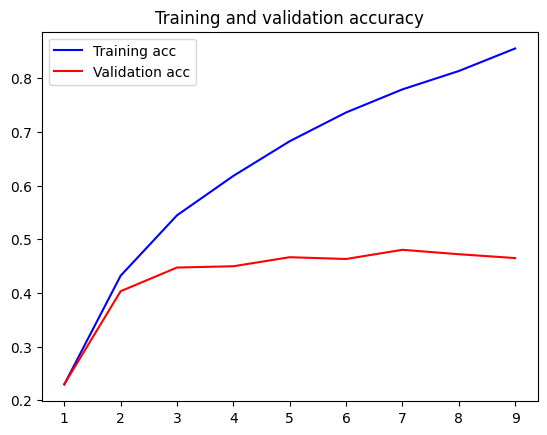

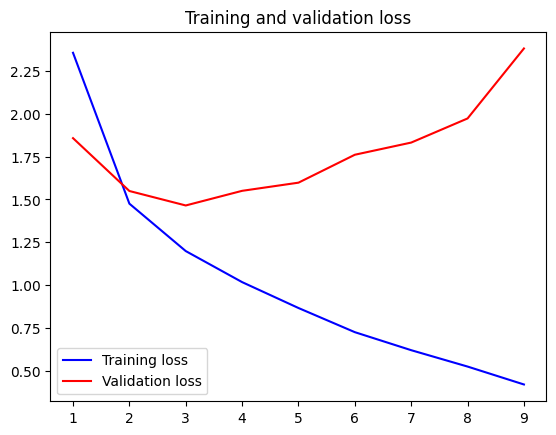

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

On the plots for loss and accuracy for train and validation data above we can see clearly see overfitting. The model learns pattern from  training data and stops to generalize on unseen data.  But when we evaluate the model we can see that it has only 44.7% accuracy.

In [ ]:
model2.evaluate(X_val, y_val_cat)

236/236 [==============================] - 2s 9ms/step - loss: 1.4643 - categorical_accuracy: 0.4473


[1.4643036127090454, 0.44731953740119934]

101/101 [==============================] - 1s 12ms/step


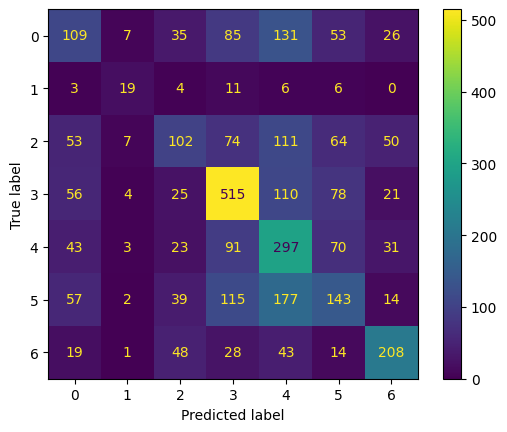

Accuracy: 0.43113587124729186
Recall: [0.24439462 0.3877551  0.22125813 0.63658838 0.53225806 0.26142596
 0.57617729]
Precision: [0.32058824 0.44186047 0.36956522 0.56039173 0.33942857 0.33411215
 0.59428571]
Precision: [0.27735369 0.41304348 0.27679783 0.59606481 0.414515   0.29333333
 0.58509142]


In [ ]:
predicted=np.argmax(model2.predict(X_test), axis=1)
predicted

remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)


As we can see in the confusion matrix, the model started to learn the classes.The accuracy on the test data is 43.11%  As we see the diagonal in the confusion matrix it learned the classes.
We will try to prevent overfitting with some regularization methods

### Third model

In the third model we added regularization and slightly changed the model architecture. We have four CNN layers (254,128,512 and 128 neurons) . We have also three dense layers( 512,512,254) We added  l2 regularizer with rate 0.1, batch normalization, max pooling and dropout (rate=0.3).The output contains 7 neurons.
We use categorical accuracy as the validation metric and categorical crossentropy as loss. We use also Adam optimizer with learning rate 1e-3.

In [ ]:
#model2.save("../Model/CNN.h5")

In [ ]:
model3 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(254, (3,3), activation='relu',padding = 'same', input_shape=(48, 48, 1),kernel_regularizer=tf.keras.regularizers.l2(0.1)),
   tf.keras.layers.BatchNormalization(),
   # tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu' ,padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
 #   tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu' ,padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
 #   tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Dense(254,kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)  # Output layer with 10 classes (CIFAR-10)
])

metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model3.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss=loss,
              metrics=[metric_accuracy])

We train the modek for 50 epochs. The batch size is 128. For training we use the training iterator and validation iterator for validation. We also use the early stopping - if the valindetion loss does not improve in the six following epoch, we stop the training in order to ommit overfitting.


In [ ]:
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
)



history =model3.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val_cat),

)


Epoch 1/50
345/345 [==============================] - 40s 107ms/step - loss: 126.2403 - categorical_accuracy: 0.1610 - val_loss: 64.1710 - val_categorical_accuracy: 0.0913
Epoch 2/50
345/345 [==============================] - 36s 104ms/step - loss: 37.2925 - categorical_accuracy: 0.1974 - val_loss: 18.9895 - val_categorical_accuracy: 0.1194
Epoch 3/50
345/345 [==============================] - 36s 105ms/step - loss: 11.4025 - categorical_accuracy: 0.2870 - val_loss: 6.5077 - val_categorical_accuracy: 0.3187
Epoch 4/50
345/345 [==============================] - 36s 104ms/step - loss: 4.5724 - categorical_accuracy: 0.4333 - val_loss: 3.5376 - val_categorical_accuracy: 0.4148
Epoch 5/50
345/345 [==============================] - 36s 104ms/step - loss: 2.9200 - categorical_accuracy: 0.5180 - val_loss: 2.7057 - val_categorical_accuracy: 0.4663
Epoch 6/50
345/345 [==============================] - 36s 104ms/step - loss: 2.4831 - categorical_accuracy: 0.5438 - val_loss: 2.3880 - val_categoric

Due to early stopping, we fininshed trainng after 25 epochs.

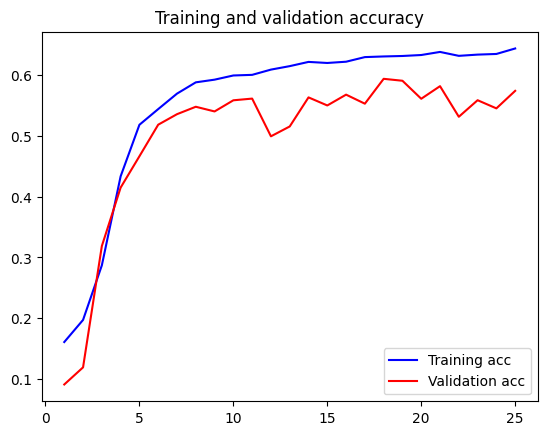

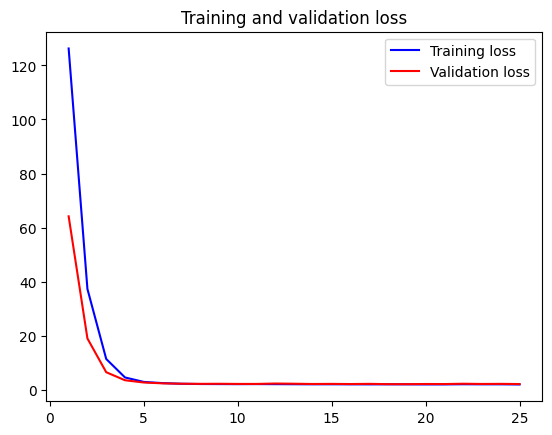

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

On the plots for loss and accuracy for train and validation data above we can  see that the lines are close to another. When we evaluate the model we can see that it has  59% accuracy.

In [ ]:
model3.evaluate(X_val, y_val_cat)

236/236 [==============================] - 2s 7ms/step - loss: 2.0890 - categorical_accuracy: 0.5904


[2.0890305042266846, 0.5903662443161011]

In [ ]:
model3.save("../content/drive/MyDrive/ComputerVision/Models/CNN_regularized.h5")

101/101 [==============================] - 1s 7ms/step


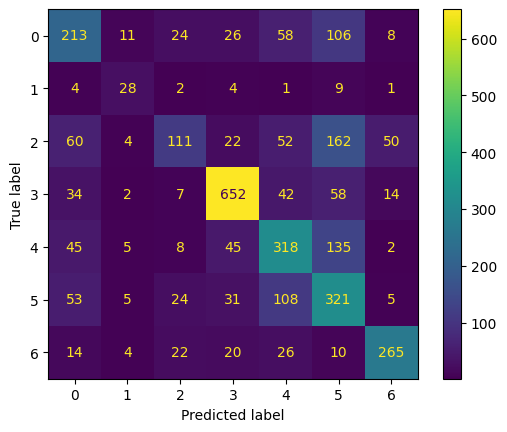

Accuracy: 0.5905292479108635
Recall: [0.47757848 0.57142857 0.24078091 0.80593325 0.56989247 0.58683729
 0.73407202]
Precision: [0.5035461  0.47457627 0.56060606 0.815      0.52561983 0.40074906
 0.76811594]
Precision: [0.49021864 0.51851852 0.33687405 0.81044127 0.54686156 0.47626113
 0.75070822]


In [ ]:
predicted=np.argmax(model3.predict(X_test), axis=1)
predicted

remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)


As we can see in the confusion matrix, the model learns the classes. The accuracy on the test data is 59%  As we see the diagonal in the confusion matrix it learned the classes. It is better but still not perfect.
We will try to use regularization methods with a bit bigger model to learnmore patterns from data and improve performance. The model has problems with the class "disgust".

### Fourth model

In the fourth model we still have a bit smaller regularization and slightly changed the model architecture. We have four CNN layers (254,128,512 and 128 neurons). We have also four dense layers( 512,512,254,254) We added  l2 regularizer with rate 0.1, batch normalization, max pooling and dropout (rate=0.3).The output contains 7 neurons.
We use categorical accuracy as the validation metric and categorical crossentropy as loss. We use also Adam optimizer with learning rate 1e-3.

In [ ]:
model4 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(254, (3,3), activation='relu',padding = 'same', input_shape=(48, 48, 1),kernel_regularizer=tf.keras.regularizers.l2(0.05)),
   tf.keras.layers.BatchNormalization(),
   # tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu' ,padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
 #   tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),



    tf.keras.layers.Conv2D(128, (3,3), activation='relu' ,padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
 #   tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(254,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(254,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),


   # tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    #tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)  # Output layer with 10 classes (CIFAR-10)
])

metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model4.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss=loss,
              metrics=[metric_accuracy])

We train the modek for 50 epochs. The batch size is 128. For training we use the training iterator and validation iterator for validation. We also use the early stopping - if the valindetion loss does not improve in the six following epoch, we stop the training in order to ommit overfitting.

In [ ]:
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
)



history =model4.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val_cat),

)


Epoch 1/50
345/345 [==============================] - 49s 106ms/step - loss: 85.6242 - categorical_accuracy: 0.1640 - val_loss: 56.6826 - val_categorical_accuracy: 0.0699
Epoch 2/50
345/345 [==============================] - 36s 103ms/step - loss: 39.7629 - categorical_accuracy: 0.2024 - val_loss: 26.1476 - val_categorical_accuracy: 0.1645
Epoch 3/50
345/345 [==============================] - 36s 104ms/step - loss: 18.2334 - categorical_accuracy: 0.2642 - val_loss: 12.0158 - val_categorical_accuracy: 0.3357
Epoch 4/50
345/345 [==============================] - 36s 106ms/step - loss: 8.6047 - categorical_accuracy: 0.3791 - val_loss: 6.0727 - val_categorical_accuracy: 0.4037
Epoch 5/50
345/345 [==============================] - 36s 105ms/step - loss: 4.6622 - categorical_accuracy: 0.4736 - val_loss: 3.6840 - val_categorical_accuracy: 0.4896
Epoch 6/50
345/345 [==============================] - 36s 105ms/step - loss: 3.0539 - categorical_accuracy: 0.5448 - val_loss: 2.6869 - val_categoric

 Due to early stopping, we fininshed trainnig after 16 epochs.

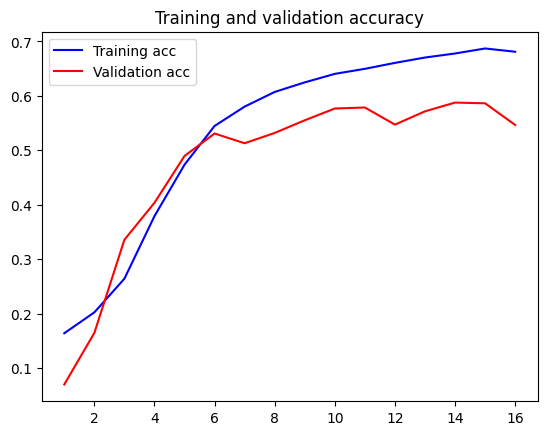

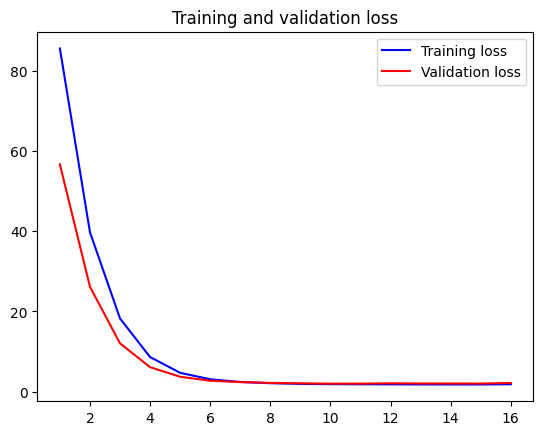

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

On the plots for accuracy for train and validation data above we can see the gap between training and validation accuracy. The plots for loss look fine. When we evaluate the model we can see that it has 57% accuracy. As the more complex model did not help, we will move to neural networks using pretrained models.

In [ ]:
model4.evaluate(X_val, y_val_cat)

236/236 [==============================] - 2s 8ms/step - loss: 1.9549 - categorical_accuracy: 0.5768


[1.9549261331558228, 0.5768312215805054]

101/101 [==============================] - 1s 7ms/step


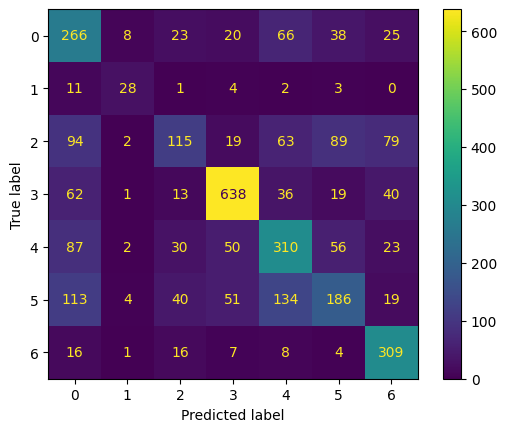

Accuracy: 0.5731971525843392
Recall: [0.59641256 0.57142857 0.2494577  0.78862794 0.55555556 0.34003656
 0.85595568]
Precision: [0.40986133 0.60869565 0.48319328 0.8086185  0.50080775 0.47088608
 0.62424242]
Precision: [0.48584475 0.58947368 0.32904149 0.79849812 0.52676296 0.39490446
 0.72196262]


In [ ]:
predicted=np.argmax(model4.predict(X_test), axis=1)
predicted

remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)
